In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.table import Table

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import chi2_contingency

from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTE
from scipy.stats import chi2_contingency
from imblearn.under_sampling import RandomUnderSampler

In [2]:
df = pd.read_excel('Dataset.xlsx')

## Clean Data

In [3]:
# Get the list of columns to convert to categorical
categorical_columns = df.select_dtypes(include='int64').columns.tolist()

# Convert the selected columns to categorical
df[categorical_columns] = df[categorical_columns].astype('category')

numeric_data = df.select_dtypes(include=[np.number])

# Calculate MAD for each column
mad = numeric_data.mad()

# Choose a threshold multiplier
k = 3

# Calculate the threshold value
threshold = k * mad

# Identify outliers
outliers = (np.abs(numeric_data - numeric_data.median()) > threshold)

# Apply logarithm to the specified columns
outlier_columns = ['CommissionSacrificePercentage', 'BonusCommissionPercentage']
for column in outlier_columns:
    df[column] = np.log1p(df[column])

numeric_data = df.select_dtypes(include=[np.number])

# Check that all outliers have been handled
outliers = (np.abs(numeric_data - numeric_data.median()) > threshold)

# Count the number of outliers in each column
outlier_counts = outliers.sum()

# Create a new DataFrame from outlier_counts
outlier_table = pd.DataFrame({'Column': outlier_counts.index, 'Outlier Count': outlier_counts.values})

# Display the table
print(outlier_table)

                          Column  Outlier Count
0  CommissionSacrificePercentage              0
1      BonusCommissionPercentage              0


## Feature Importance Techniques

### Random Forest Feature Importance Scoring

In [4]:
# Define features and target variable
features = ['Product', 'ProductGroup', 'ProductType', 'Agency', 'WorkflowStatus', 'Indexation', 'NoOfLives',
            'CommDateProvided', 'PaymentFreq', 'UWDecision', 'ComissionSacrifice', 'CommissionSacrificeType',
            'RenewalSacrificeType', 'CommissionTerms', 'Discount', 'BonusCommission', 'FreeCover',
            'SeriousIllnessType', 'SignedDecReceived']
target = 'PolicyIssued'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Get feature importances
feature_importances = pd.Series(rf_classifier.feature_importances_, index=features).sort_values(ascending=False)

# Print feature importances
print("Feature Importances:")
print(feature_importances)

Feature Importances:
Agency                     0.559780
WorkflowStatus             0.173468
UWDecision                 0.118432
CommDateProvided           0.033788
SignedDecReceived          0.013722
NoOfLives                  0.013316
ProductGroup               0.011579
SeriousIllnessType         0.011124
BonusCommission            0.011008
Product                    0.010811
CommissionTerms            0.010571
Indexation                 0.009274
ProductType                0.006298
RenewalSacrificeType       0.004066
CommissionSacrificeType    0.003736
ComissionSacrifice         0.003247
Discount                   0.002656
PaymentFreq                0.002633
FreeCover                  0.000490
dtype: float64


In [5]:
# Select the top-n features based on importance
n = 4 
selected_features = feature_importances[:n].index.tolist()

In [6]:
# Create a new dataset with the selected features
selected_data = df[selected_features + [target]]

In [7]:
# Conduct experiments by training and evaluating the model on different feature combinations
for feature_combination in range(1, n + 1):
    selected_features_combination = selected_features[:feature_combination]
    X_train_combination = X_train[selected_features_combination]
    X_test_combination = X_test[selected_features_combination]

    rf_classifier_combination = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier_combination.fit(X_train_combination, y_train)
    y_pred_combination = rf_classifier_combination.predict(X_test_combination)

    accuracy = accuracy_score(y_test, y_pred_combination)
    report = classification_report(y_test, y_pred_combination)
    print(f"\nExperiment with {feature_combination} features:")
    print(f"Selected Features: {selected_features_combination}")
    print(f"Accuracy: {accuracy}")
    print(f"Classification Report:\n{report}")


Experiment with 1 features:
Selected Features: ['Agency']
Accuracy: 0.779639462054494
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.03      0.06      6973
           1       0.78      0.99      0.88     24480

    accuracy                           0.78     31453
   macro avg       0.67      0.51      0.47     31453
weighted avg       0.73      0.78      0.69     31453


Experiment with 2 features:
Selected Features: ['Agency', 'WorkflowStatus']
Accuracy: 0.7996057609766953
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.35      0.44      6973
           1       0.83      0.93      0.88     24480

    accuracy                           0.80     31453
   macro avg       0.71      0.64      0.66     31453
weighted avg       0.78      0.80      0.78     31453


Experiment with 3 features:
Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision']
Accuracy: 0.8020

#### Try different test sizes and different n estimators

In [8]:
# Define different test sizes and n estimator values to test
test_sizes = [0.2, 0.25, 0.3, 0.33]
n_estimators_values = [50, 100, 150, 200]
n_values = [4,5,6,7]

# Iterate through each test size and n estimator value
for test_size in test_sizes:
    for n_estimators_value in n_estimators_values:
        # Split the data into training and testing sets with the current test size
        X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=test_size, random_state=42)

        # Train a Random Forest classifier with the current n estimator value
        rf_classifier = RandomForestClassifier(n_estimators=n_estimators_value, random_state=42)
        rf_classifier.fit(X_train, y_train)

        # Get feature importances
        feature_importances = pd.Series(rf_classifier.feature_importances_, index=features).sort_values(ascending=False)

        # Print feature importances for the current test size and n estimator value
        print(f"\nTest Size: {test_size}, n_estimators: {n_estimators_value}")
        print("Feature Importances:")
        print(feature_importances)

        # Select the top-n features based on importance
        for n in n_values:
            selected_features = feature_importances[:n].index.tolist()

            # Create a new dataset with the selected features
            selected_data = df[selected_features + [target]]

            # Train and evaluate the model with the current feature combination
            X_train_selected = X_train[selected_features]
            X_test_selected = X_test[selected_features]

            rf_classifier_selected = RandomForestClassifier(n_estimators=n_estimators_value, random_state=42)
            rf_classifier_selected.fit(X_train_selected, y_train)
            y_pred_selected = rf_classifier_selected.predict(X_test_selected)

            accuracy = accuracy_score(y_test, y_pred_selected)
            report = classification_report(y_test, y_pred_selected)
            print(f"Selected Features: {selected_features}")
            print(f"Accuracy: {accuracy}")
            print(f"Classification Report:\n{report}")


Test Size: 0.2, n_estimators: 50
Feature Importances:
Agency                     0.560283
WorkflowStatus             0.171679
UWDecision                 0.117542
CommDateProvided           0.036348
NoOfLives                  0.014011
SignedDecReceived          0.013423
ProductGroup               0.012310
Product                    0.011039
BonusCommission            0.010791
SeriousIllnessType         0.010695
CommissionTerms            0.010358
Indexation                 0.009120
ProductType                0.005754
RenewalSacrificeType       0.003982
CommissionSacrificeType    0.003621
ComissionSacrifice         0.003282
Discount                   0.002636
PaymentFreq                0.002599
FreeCover                  0.000528
dtype: float64
Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided']
Accuracy: 0.8017359234413252
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.37      0.45      6973
   

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided']
Accuracy: 0.8017995103805678
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.37      0.45      6973
           1       0.84      0.93      0.88     24480

    accuracy                           0.80     31453
   macro avg       0.71      0.65      0.66     31453
weighted avg       0.78      0.80      0.78     31453

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'NoOfLives']
Accuracy: 0.8006867389438209
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.37      0.45      6973
           1       0.84      0.92      0.88     24480

    accuracy                           0.80     31453
   macro avg       0.71      0.65      0.67     31453
weighted avg       0.78      0.80      0.78     31453

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'Co

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'NoOfLives']
Accuracy: 0.8013277037338488
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.39      0.46      8650
           1       0.84      0.92      0.88     30666

    accuracy                           0.80     39316
   macro avg       0.71      0.65      0.67     39316
weighted avg       0.78      0.80      0.79     39316

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'NoOfLives', 'SignedDecReceived']
Accuracy: 0.7971055041204599
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.39      0.46      8650
           1       0.84      0.91      0.88     30666

    accuracy                           0.80     39316
   macro avg       0.70      0.65      0.67     39316
weighted avg       0.78      0.80      0.78     39316

Selected Features: ['Agency', '

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives']
Accuracy: 0.7963288751351236
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.40      0.46     10413
           1       0.84      0.91      0.87     36766

    accuracy                           0.80     47179
   macro avg       0.70      0.65      0.67     47179
weighted avg       0.78      0.80      0.78     47179

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'BonusCommission']
Accuracy: 0.7916021958922402
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.40      0.46     10413
           1       0.84      0.90      0.87     36766

    accuracy                           0.79     47179
   macro avg       0.69      0.65      0.67     47179
weighted avg       0.77      0.79      0.78   

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup']
Accuracy: 0.7922037882729253
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.40      0.46     11494
           1       0.84      0.90      0.87     40403

    accuracy                           0.79     51897
   macro avg       0.69      0.65      0.67     51897
weighted avg       0.77      0.79      0.78     51897


Test Size: 0.33, n_estimators: 100
Feature Importances:
Agency                     0.564858
WorkflowStatus             0.175017
UWDecision                 0.108815
CommDateProvided           0.033528
SignedDecReceived          0.013987
NoOfLives                  0.013651
SeriousIllnessType         0.011698
BonusCommission            0.011642
ProductGroup               0.011488
Product                    0.011156
CommissionTerms            0.010968
Indexation                 0.009743


In [9]:
# Create empty lists to store results
results = []
feature_importances_dict = {}

# Iterate through each test size and n estimator value
for test_size in test_sizes:
    for n_estimators_value in n_estimators_values:
        # Split the data into training and testing sets with the current test size
        X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=test_size, random_state=42)

        # Train a Random Forest classifier with the current n estimator value
        rf_classifier = RandomForestClassifier(n_estimators=n_estimators_value, random_state=42)
        rf_classifier.fit(X_train, y_train)

        # Get feature importances
        feature_importances = pd.Series(rf_classifier.feature_importances_, index=features).sort_values(ascending=False)

        # Store feature importances in dictionary for visualization
        feature_importances_dict[(test_size, n_estimators_value)] = feature_importances

        # Select the top-n features based on importance
        for n in n_values:
            selected_features = feature_importances[:n].index.tolist()

            # Create a new dataset with the selected features
            selected_data = df[selected_features + [target]]

            # Train and evaluate the model with the current feature combination
            X_train_selected = X_train[selected_features]
            X_test_selected = X_test[selected_features]

            rf_classifier_selected = RandomForestClassifier(n_estimators=n_estimators_value, random_state=42)
            rf_classifier_selected.fit(X_train_selected, y_train)
            y_pred_selected = rf_classifier_selected.predict(X_test_selected)

            accuracy = accuracy_score(y_test, y_pred_selected)
            results.append((test_size, n_estimators_value, n, accuracy))

In [10]:
results

[(0.2, 50, 4, 0.8017359234413252),
 (0.2, 50, 5, 0.8019902711982959),
 (0.2, 50, 6, 0.7962674466664547),
 (0.2, 50, 7, 0.7925794041903793),
 (0.2, 100, 4, 0.8023717928337519),
 (0.2, 100, 5, 0.7976345658601723),
 (0.2, 100, 6, 0.7953772295170572),
 (0.2, 100, 7, 0.7927701650081074),
 (0.2, 150, 4, 0.8016723365020825),
 (0.2, 150, 5, 0.8009092932311703),
 (0.2, 150, 6, 0.7958541315613773),
 (0.2, 150, 7, 0.7927065780688647),
 (0.2, 200, 4, 0.8017995103805678),
 (0.2, 200, 5, 0.8006867389438209),
 (0.2, 200, 6, 0.7955044033955425),
 (0.2, 200, 7, 0.7921978825549232),
 (0.25, 50, 4, 0.8027520602299318),
 (0.25, 50, 5, 0.8012768338589887),
 (0.25, 50, 6, 0.7967748499338692),
 (0.25, 50, 7, 0.7933156984433818),
 (0.25, 100, 4, 0.8030318445416624),
 (0.25, 100, 5, 0.8016837928578696),
 (0.25, 100, 6, 0.7974107233696205),
 (0.25, 100, 7, 0.7931376538813715),
 (0.25, 150, 4, 0.8031590192288127),
 (0.25, 150, 5, 0.8013277037338488),
 (0.25, 150, 6, 0.7971055041204599),
 (0.25, 150, 7, 0.7921965

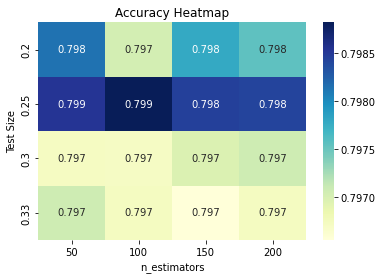

In [21]:
# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=["Test Size", "n_estimators", "n_features", "Accuracy"])

# Visualise Accuracy with Heatmap
heatmap_data = results_df.pivot_table(index="Test Size", columns="n_estimators", values="Accuracy")
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Accuracy Heatmap")
plt.show()

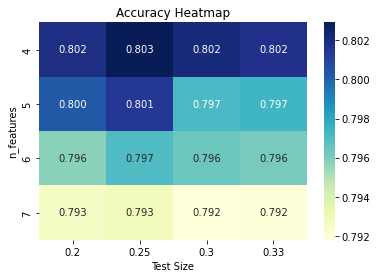

In [22]:
# Visualise Accuracy with Heatmap
heatmap_data = results_df.pivot_table(index="n_features", columns="Test Size", values="Accuracy")
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Accuracy Heatmap")
plt.show()

In [27]:
feature_importance_stats = {}
for feature in features:
    feature_importance_stats[feature] = {
        'Min': min(importance[feature] for importance in feature_importances_dict.values()),
        'Max': max(importance[feature] for importance in feature_importances_dict.values()),
        'Mean': sum(importance[feature] for importance in feature_importances_dict.values()) / len(feature_importances_dict),
        'Median': pd.Series([importance[feature] for importance in feature_importances_dict.values()]).median()
    }

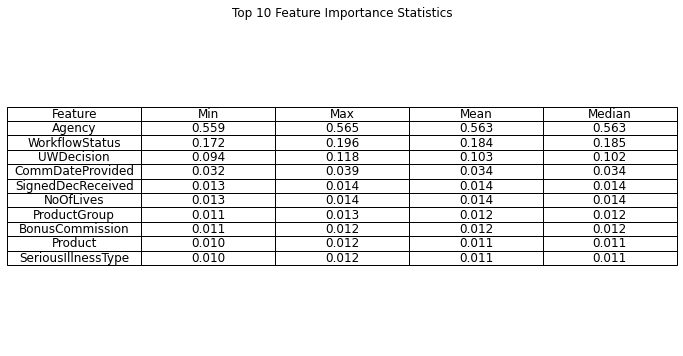

In [38]:
# Create a DataFrame from feature importance statistics
feature_importance_stats_df = pd.DataFrame(feature_importance_stats).T

# Sort features by Mean importance and select top 10
top_10_features = feature_importance_stats_df.sort_values(by='Mean', ascending=False).head(10)

# Define statistics and colors
statistics = ['Min', 'Max', 'Mean', 'Median']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create a table of feature importance statistics
table_data = []
for feature, row in top_10_features.iterrows():
    row_values = [f"{row[stat]:.3f}" for stat in statistics]
    table_data.append([feature] + row_values)

table = ax.table(cellText=table_data, colLabels=['Feature'] + statistics, cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

ax.axis('off')

ax.set_title('Top 10 Feature Importance Statistics')

plt.show()

The feature importance scoring built into random forest appears to be suggesting that the same four independent variables as identifed with Cramer's V are the most important predictors of Policy Issuance.

### Gradient Boosting Feature Importance Scoring

In [45]:
# Create empty lists to store results
results = []
feature_importances_dict = {}

# Iterate through each test size and n estimator value
for test_size in test_sizes:
    for n_estimators_value in n_estimators_values:
        # Split the data into training and testing sets with the current test size
        X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=test_size, random_state=42)

        # Train a Gradient Boosting classifier
        gb_classifier = GradientBoostingClassifier(n_estimators=n_estimators_value, random_state=42)
        gb_classifier.fit(X_train, y_train)

        # Get feature importances
        feature_importances = pd.Series(gb_classifier.feature_importances_, index=features).sort_values(ascending=False)

        # Store feature importances in dictionary for visualization
        feature_importances_dict[(test_size, n_estimators_value)] = feature_importances
        
        # Select the top-n features based on importance
        for n in n_values:
            selected_features = feature_importances[:n].index.tolist()

            # Create a new dataset with the selected features
            selected_data = df[selected_features + [target]]

            # Train and evaluate the model with the current feature combination
            X_train_selected = X_train[selected_features]
            X_test_selected = X_test[selected_features]

            gb_classifier_selected = GradientBoostingClassifier(n_estimators=n_estimators_value, random_state=42)
            gb_classifier_selected.fit(X_train_selected, y_train)
            y_pred_selected = gb_classifier_selected.predict(X_test_selected)

            accuracy = accuracy_score(y_test, y_pred_selected)
            results.append((test_size, n_estimators_value, n, accuracy))

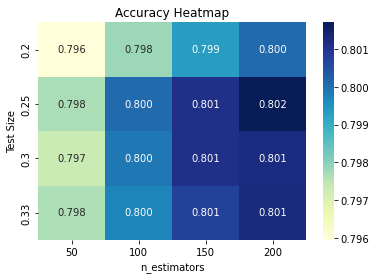

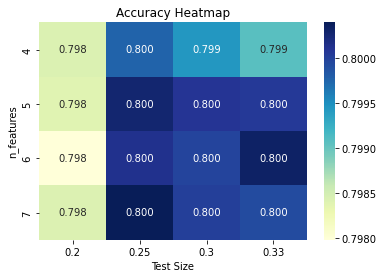

In [46]:
# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=["Test Size", "n_estimators", "n_features", "Accuracy"])

# Visualise Accuracy with Heatmap
heatmap_data = results_df.pivot_table(index="Test Size", columns="n_estimators", values="Accuracy")
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Accuracy Heatmap")
plt.show()

heatmap_data = results_df.pivot_table(index="n_features", columns="Test Size", values="Accuracy")
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Accuracy Heatmap")
plt.show()

In [47]:
feature_importance_stats = {}
for feature in features:
    feature_importance_stats[feature] = {
        'Min': min(importance[feature] for importance in feature_importances_dict.values()),
        'Max': max(importance[feature] for importance in feature_importances_dict.values()),
        'Mean': sum(importance[feature] for importance in feature_importances_dict.values()) / len(feature_importances_dict),
        'Median': pd.Series([importance[feature] for importance in feature_importances_dict.values()]).median()
    }

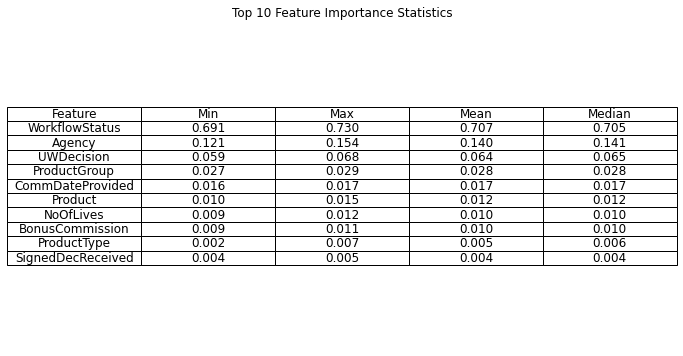

In [48]:
# Create a DataFrame from feature importance statistics
feature_importance_stats_df = pd.DataFrame(feature_importance_stats).T

# Sort features by Mean importance and select top 10
top_10_features = feature_importance_stats_df.sort_values(by='Mean', ascending=False).head(10)

# Define statistics and colors
statistics = ['Min', 'Max', 'Mean', 'Median']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create a table of feature importance statistics
table_data = []
for feature, row in top_10_features.iterrows():
    row_values = [f"{row[stat]:.3f}" for stat in statistics]
    table_data.append([feature] + row_values)

table = ax.table(cellText=table_data, colLabels=['Feature'] + statistics, cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

ax.axis('off')


ax.set_title('Top 10 Feature Importance Statistics')

plt.show()

### LightGBM Feature Importance Scoring

In [66]:
# Create empty lists to store results
results = []
feature_importances_dict = {}

# Iterate through each test size and n estimator value
for test_size in test_sizes:
    for n_estimators_value in n_estimators_values:
        # Split the data into training and testing sets with the current test size
        X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=test_size, random_state=42)

        # Train a LightGBM classifier
        lgb_classifier = lgb.LGBMClassifier(n_estimators=n_estimators_value, random_state=42)
        lgb_classifier.fit(X_train, y_train)

        # Get feature importances
        feature_importances = pd.Series(lgb_classifier.feature_importances_, index=features).sort_values(ascending=False)

        # Store feature importances in dictionary for visualisation
        feature_importances_dict[(test_size, n_estimators_value)] = feature_importances
        
        # Select the top-n features based on importance
        for n in n_values:
            selected_features = feature_importances[:n].index.tolist()

            # Create a new dataset with the selected features
            selected_data = df[selected_features + [target]]

            # Train and evaluate the model with the current feature combination
            X_train_selected = X_train[selected_features]
            X_test_selected = X_test[selected_features]

            lgb_classifier_selected = lgb.LGBMClassifier(n_estimators=n_estimators_value, random_state=42)
            lgb_classifier_selected.fit(X_train_selected, y_train)
            y_pred_selected = lgb_classifier_selected.predict(X_test_selected)

            accuracy = accuracy_score(y_test, y_pred_selected)
            results.append((test_size, n_estimators_value, n, accuracy))

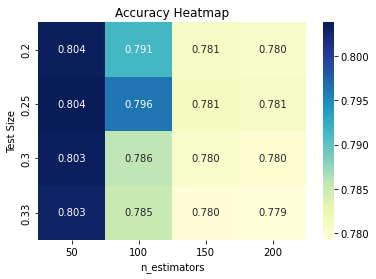

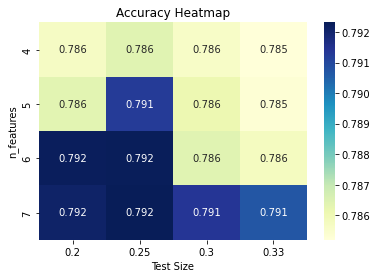

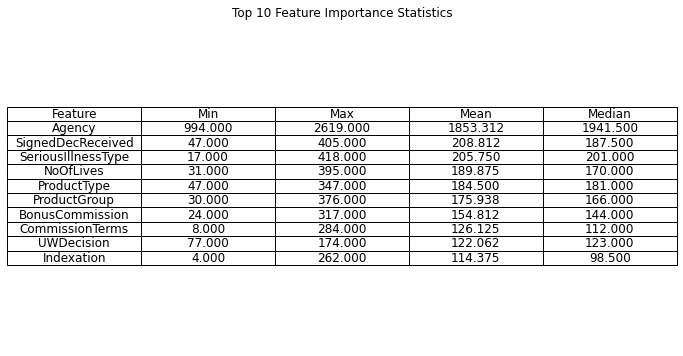

In [67]:
# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=["Test Size", "n_estimators", "n_features", "Accuracy"])

# Visualise Accuracy with Heatmap
heatmap_data = results_df.pivot_table(index="Test Size", columns="n_estimators", values="Accuracy")
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Accuracy Heatmap")
plt.show()

heatmap_data = results_df.pivot_table(index="n_features", columns="Test Size", values="Accuracy")
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Accuracy Heatmap")
plt.show()

feature_importance_stats = {}
for feature in features:
    feature_importance_stats[feature] = {
        'Min': min(importance[feature] for importance in feature_importances_dict.values()),
        'Max': max(importance[feature] for importance in feature_importances_dict.values()),
        'Mean': sum(importance[feature] for importance in feature_importances_dict.values()) / len(feature_importances_dict),
        'Median': pd.Series([importance[feature] for importance in feature_importances_dict.values()]).median()
    }
    
# Create a DataFrame from feature importance statistics
feature_importance_stats_df = pd.DataFrame(feature_importance_stats).T

# Sort features by Mean importance and select top 10
top_10_features = feature_importance_stats_df.sort_values(by='Mean', ascending=False).head(10)

# Define statistics and colors
statistics = ['Min', 'Max', 'Mean', 'Median']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create a table of feature importance statistics
table_data = []
for feature, row in top_10_features.iterrows():
    row_values = [f"{row[stat]:.3f}" for stat in statistics]
    table_data.append([feature] + row_values)

table = ax.table(cellText=table_data, colLabels=['Feature'] + statistics, cellLoc='center', loc='center')


table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

ax.axis('off')
ax.set_title('Top 10 Feature Importance Statistics')

plt.show()

### Cramer's V on training data only

In [5]:
# Define features and target variable
features = ['Product', 'ProductGroup', 'ProductType', 'Agency', 'WorkflowStatus', 'Indexation', 'NoOfLives',
            'CommDateProvided', 'PaymentFreq', 'UWDecision', 'ComissionSacrifice', 'CommissionSacrificeType',
            'RenewalSacrificeType', 'CommissionTerms', 'Discount', 'BonusCommission', 'FreeCover',
            'SeriousIllnessType', 'SignedDecReceived']
target = 'PolicyIssued'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)


In [12]:
# Combine X_train and y_train into a single DataFrame
train_data = pd.concat([X_train, y_train], axis=1)

In [13]:
# Perform chi-square test for each pair of categorical variables
for column1 in train_data.select_dtypes(include='category'):
    for column2 in train_data.select_dtypes(include='category'):
        if column1 != column2:
            contingency_table = pd.crosstab(train_data[column1], train_data[column2])
            chi2, p_value, _, _ = chi2_contingency(contingency_table)
            print(f"Chi-square Test: {column1} vs. {column2}")
            print(f"Chi2 Statistic: {chi2}")
            print(f"P-value: {p_value}")
            print()

Chi-square Test: Product vs. ProductGroup
Chi2 Statistic: 377430.00000000006
P-value: 0.0

Chi-square Test: Product vs. ProductType
Chi2 Statistic: 377430.0
P-value: 0.0

Chi-square Test: Product vs. Agency
Chi2 Statistic: 169332.82612637506
P-value: 0.0

Chi-square Test: Product vs. WorkflowStatus
Chi2 Statistic: 1144.3613469118532
P-value: 1.7587962974115753e-226

Chi-square Test: Product vs. Indexation
Chi2 Statistic: 30040.89313029918
P-value: 0.0

Chi-square Test: Product vs. NoOfLives
Chi2 Statistic: 21354.21252555173
P-value: 0.0

Chi-square Test: Product vs. CommDateProvided
Chi2 Statistic: 880.4274985651399
P-value: 6.395406281926485e-187

Chi-square Test: Product vs. PaymentFreq
Chi2 Statistic: 125999.3441392096
P-value: 0.0

Chi-square Test: Product vs. UWDecision
Chi2 Statistic: 132885.7070570088
P-value: 0.0

Chi-square Test: Product vs. ComissionSacrifice
Chi2 Statistic: 4423.53111777354
P-value: 0.0

Chi-square Test: Product vs. CommissionSacrificeType
Chi2 Statistic: 45

Chi-square Test: WorkflowStatus vs. BonusCommission
Chi2 Statistic: 252.48463731380082
P-value: 1.8979693684546444e-53

Chi-square Test: WorkflowStatus vs. FreeCover
Chi2 Statistic: 87918.64964297588
P-value: 0.0

Chi-square Test: WorkflowStatus vs. SeriousIllnessType
Chi2 Statistic: 202.212437542524
P-value: 2.1840279817798798e-39

Chi-square Test: WorkflowStatus vs. SignedDecReceived
Chi2 Statistic: 4035.0676725958087
P-value: 0.0

Chi-square Test: WorkflowStatus vs. PolicyIssued
Chi2 Statistic: 20881.940468101537
P-value: 0.0

Chi-square Test: Indexation vs. Product
Chi2 Statistic: 30040.89313029918
P-value: 0.0

Chi-square Test: Indexation vs. ProductGroup
Chi2 Statistic: 29575.949010439577
P-value: 0.0

Chi-square Test: Indexation vs. ProductType
Chi2 Statistic: 2312.5352548504475
P-value: 0.0

Chi-square Test: Indexation vs. Agency
Chi2 Statistic: 39085.5050941744
P-value: 0.0

Chi-square Test: Indexation vs. WorkflowStatus
Chi2 Statistic: 18.989209560583966
P-value: 0.0007897899

Chi-square Test: PaymentFreq vs. FreeCover
Chi2 Statistic: 0.45784630423154504
P-value: 0.7953896551686648

Chi-square Test: PaymentFreq vs. SeriousIllnessType
Chi2 Statistic: 12.146400226067074
P-value: 0.01629516073203777

Chi-square Test: PaymentFreq vs. SignedDecReceived
Chi2 Statistic: 17.550897541835365
P-value: 0.0001544795595667678

Chi-square Test: PaymentFreq vs. PolicyIssued
Chi2 Statistic: 7.648970855047537
P-value: 0.0218296655865324

Chi-square Test: UWDecision vs. Product
Chi2 Statistic: 132885.70705700884
P-value: 0.0

Chi-square Test: UWDecision vs. ProductGroup
Chi2 Statistic: 129633.85814459878
P-value: 0.0

Chi-square Test: UWDecision vs. ProductType
Chi2 Statistic: 130763.54930964933
P-value: 0.0

Chi-square Test: UWDecision vs. Agency
Chi2 Statistic: 79958.18009747255
P-value: 0.0

Chi-square Test: UWDecision vs. WorkflowStatus
Chi2 Statistic: 60004.37943844445
P-value: 0.0

Chi-square Test: UWDecision vs. Indexation
Chi2 Statistic: 401.29009459161665
P-value: 1.5

Chi-square Test: RenewalSacrificeType vs. SeriousIllnessType
Chi2 Statistic: 480.3205482828594
P-value: 1.4564888943331515e-100

Chi-square Test: RenewalSacrificeType vs. SignedDecReceived
Chi2 Statistic: 250.20549385619424
P-value: 5.907194676539434e-54

Chi-square Test: RenewalSacrificeType vs. PolicyIssued
Chi2 Statistic: 29.78399790874185
P-value: 1.5322438700893978e-06

Chi-square Test: CommissionTerms vs. Product
Chi2 Statistic: 764.7919644981874
P-value: 6.220181839731778e-162

Chi-square Test: CommissionTerms vs. ProductGroup
Chi2 Statistic: 583.4871404964865
P-value: 3.828912316748986e-126

Chi-square Test: CommissionTerms vs. ProductType
Chi2 Statistic: 310.6662412924917
P-value: 4.888337661718517e-67

Chi-square Test: CommissionTerms vs. Agency
Chi2 Statistic: 87068.44832364147
P-value: 0.0

Chi-square Test: CommissionTerms vs. WorkflowStatus
Chi2 Statistic: 642.5295278916278
P-value: 9.65380698070812e-138

Chi-square Test: CommissionTerms vs. Indexation
Chi2 Statistic: 844.

Chi-square Test: FreeCover vs. CommissionTerms
Chi2 Statistic: 24.221693551266785
P-value: 8.58597139966691e-07

Chi-square Test: FreeCover vs. Discount
Chi2 Statistic: 10.858952589055646
P-value: 0.000983192874722367

Chi-square Test: FreeCover vs. BonusCommission
Chi2 Statistic: 0.18098917405526377
P-value: 0.67052453458253

Chi-square Test: FreeCover vs. SeriousIllnessType
Chi2 Statistic: 5.454344304509246
P-value: 0.0654039809056434

Chi-square Test: FreeCover vs. SignedDecReceived
Chi2 Statistic: 648.1684802222753
P-value: 5.590253304578308e-143

Chi-square Test: FreeCover vs. PolicyIssued
Chi2 Statistic: 256.9230124260007
P-value: 8.039722264894959e-58

Chi-square Test: SeriousIllnessType vs. Product
Chi2 Statistic: 25674.75826517913
P-value: 0.0

Chi-square Test: SeriousIllnessType vs. ProductGroup
Chi2 Statistic: 11953.15833305301
P-value: 0.0

Chi-square Test: SeriousIllnessType vs. ProductType
Chi2 Statistic: 2868.402969820223
P-value: 0.0

Chi-square Test: SeriousIllnessType

In [14]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = np.sum(confusion_matrix)
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corrected = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    r_corrected = r - ((r - 1) ** 2) / (n - 1)
    k_corrected = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2_corrected / min((k_corrected - 1), (r_corrected - 1)))

# Calculate Cramer's V for each pair of categorical variables
for column1 in train_data.select_dtypes(include='category'):
    for column2 in train_data.select_dtypes(include='category'):
        if column1 != column2:
            contingency_table = pd.crosstab(train_data[column1], train_data[column2])
            v = cramers_v(contingency_table.values)
            print(f"{column1} vs. {column2}")
            print(f"Cramer's V: {v}")
            print(f"Chi2 Statistic: {chi2}")
            print(f"P-value: {p_value}")
            print()

Product vs. ProductGroup
Cramer's V: 0.9999880768091949
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

Product vs. ProductType
Cramer's V: 0.9999880768091948
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

Product vs. Agency
Cramer's V: 0.46004318630693886
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

Product vs. WorkflowStatus
Cramer's V: 0.04718439043131996
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

Product vs. Indexation
Cramer's V: 0.4886041934466126
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

Product vs. NoOfLives
Cramer's V: 0.41193140502670406
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

Product vs. CommDateProvided
Cramer's V: 0.0833692772138546
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

Product vs. PaymentFreq
Cramer's V: 0.7076106054185536
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

Product vs. 

Agency vs. UWDecision
Cramer's V: 0.33826043378132886
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

Agency vs. ComissionSacrifice
Cramer's V: 0.6826953995329468
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

Agency vs. CommissionSacrificeType
Cramer's V: 0.5272330654092011
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

Agency vs. RenewalSacrificeType
Cramer's V: 0.6026536924504385
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

Agency vs. CommissionTerms
Cramer's V: 0.8242418169724882
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

Agency vs. Discount
Cramer's V: 0.11669453444482314
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

Agency vs. BonusCommission
Cramer's V: 0.5711403276786792
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

Agency vs. FreeCover
Cramer's V: 0.22947932131111928
Chi2 Statistic: 1034.3586680042424
P-value: 6.1101899632556

NoOfLives vs. SignedDecReceived
Cramer's V: 0.026916295968664204
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

NoOfLives vs. PolicyIssued
Cramer's V: 0.07194095021941024
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

CommDateProvided vs. Product
Cramer's V: 0.0833692772138546
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

CommDateProvided vs. ProductGroup
Cramer's V: 0.06213084288294497
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

CommDateProvided vs. ProductType
Cramer's V: 0.04066473314803043
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

CommDateProvided vs. Agency
Cramer's V: 0.413446090459168
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

CommDateProvided vs. WorkflowStatus
Cramer's V: 0.4938072827137502
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

CommDateProvided vs. Indexation
Cramer's V: 0.08404811671098009
Chi2 Statistic: 1034

Cramer's V: 0.09378110818122028
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

ComissionSacrifice vs. FreeCover
Cramer's V: 0.022657406230010516
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

ComissionSacrifice vs. SeriousIllnessType
Cramer's V: 0.11721309434475302
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

ComissionSacrifice vs. SignedDecReceived
Cramer's V: 0.025056379947834054
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

ComissionSacrifice vs. PolicyIssued
Cramer's V: 0.019874504810902506
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

CommissionSacrificeType vs. Product
Cramer's V: 0.13367251517208778
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

CommissionSacrificeType vs. ProductGroup
Cramer's V: 0.12732005653810027
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

CommissionSacrificeType vs. ProductType
Cramer's V: 0.07432925980481

Discount vs. Agency
Cramer's V: 0.11669453444482313
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

Discount vs. WorkflowStatus
Cramer's V: 0.011172283000854547
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

Discount vs. Indexation
Cramer's V: 0.015246908820713927
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

Discount vs. NoOfLives
Cramer's V: 0.032928515826939245
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

Discount vs. CommDateProvided
Cramer's V: 0.046191579142534564
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

Discount vs. PaymentFreq
Cramer's V: 0.005007106919857106
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

Discount vs. UWDecision
Cramer's V: 0.007025904674452131
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

Discount vs. ComissionSacrifice
Cramer's V: 0.021957950475960383
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963

SeriousIllnessType vs. SignedDecReceived
Cramer's V: 0.013788200486199467
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

SeriousIllnessType vs. PolicyIssued
Cramer's V: 0.01601211151294924
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

SignedDecReceived vs. Product
Cramer's V: 0.02675062083148107
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

SignedDecReceived vs. ProductGroup
Cramer's V: 0.021572381610637542
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

SignedDecReceived vs. ProductType
Cramer's V: 0.02042229259229196
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

SignedDecReceived vs. Agency
Cramer's V: 0.27745713378179127
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

SignedDecReceived vs. WorkflowStatus
Cramer's V: 0.17900047673640931
Chi2 Statistic: 1034.3586680042424
P-value: 6.110189963255674e-227

SignedDecReceived vs. Indexation
Cramer's V: 0.004561017

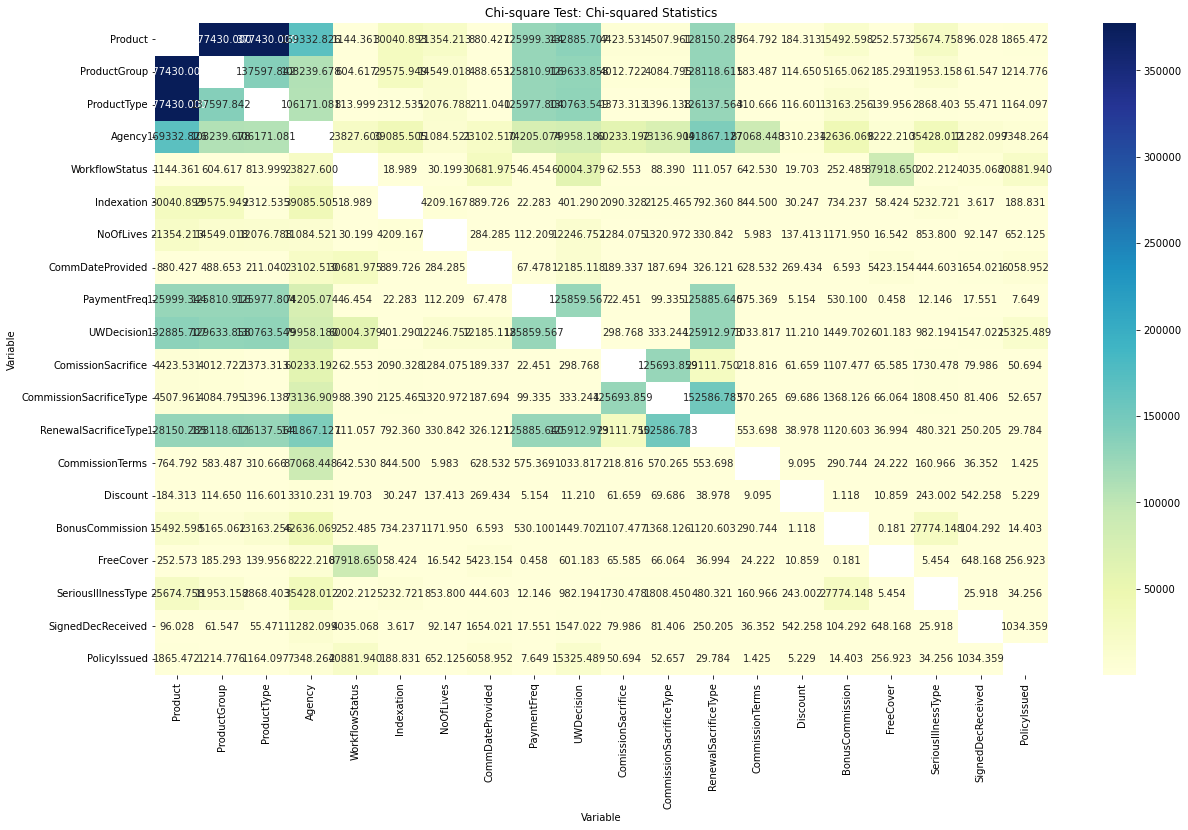

In [16]:
# Create an empty dataframe to store Chi-squared statistics
chi2_stats_df = pd.DataFrame(index=train_data.select_dtypes(include='category').columns, columns=train_data.select_dtypes(include='category').columns)

# Perform chi-square test for each pair of categorical variables
for column1 in train_data.select_dtypes(include='category'):
    for column2 in train_data.select_dtypes(include='category'):
        if column1 != column2:
            contingency_table = pd.crosstab(train_data[column1], train_data[column2])
            chi2_stat, _, _, _ = chi2_contingency(contingency_table)
            chi2_stats_df.loc[column1, column2] = chi2_stat

# Create a heatmap of the Chi-squared statistics
plt.figure(figsize=(20, 12))
sns.heatmap(chi2_stats_df.astype(float), annot=True, fmt=".3f", cmap='YlGnBu')
plt.xlabel('Variable')
plt.ylabel('Variable')
plt.title('Chi-square Test: Chi-squared Statistics')
plt.show()

According to p-values and Cramer's V, PolicyIssued has a moderate-to-strong association with WorkflowStatus and UWDecision. It has a moderate association with Agency, CommDateProvided, and SignedDecReceived.

## Rebalancing imbalanced target variable - Oversampling

#### Class Aware Feature Importance

In [19]:
df = df.drop(columns=['PropDate'])

In [21]:
# Split data into features (X) and target (y)
X = df.drop(columns=['PolicyIssued'])
y = df['PolicyIssued']

In [22]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Scaler anf Borderline SMOTE used in order to avoid the introduction of unrealistic sythetic data points

In [25]:
# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
# Resampling with BorderlineSMOTE
smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


In [27]:
# Train a RandomForestClassifier on the resampled data
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [28]:
# Calculate feature importance scores
feature_importance = rf_classifier.feature_importances_

In [29]:
# Calculate class-specific importance
class_labels = df['PolicyIssued'].unique()
class_importance = {}
for label in class_labels:
    mask = (y_train_resampled == label)
    class_importance[label] = feature_importance * mask.mean()

In [30]:
# Combine class-specific importance using weights based on class distribution
class_distribution = y_train_resampled.value_counts(normalize=True)
weighted_importance = sum(class_importance[label] * class_distribution[label] for label in class_labels)


In [32]:
# Print the weighted importance scores for each feature in descending order
importance_scores = [(feature_name, importance_score) for feature_name, importance_score in zip(X.columns, weighted_importance)]
importance_scores_sorted = sorted(importance_scores, key=lambda x: x[1], reverse=True)

for feature_name, importance_score in importance_scores_sorted:
    print(f"Feature: {feature_name}, Weighted Importance: {importance_score:.4f}")


Feature: Agency, Weighted Importance: 0.2151
Feature: WorkflowStatus, Weighted Importance: 0.1172
Feature: UWDecision, Weighted Importance: 0.0374
Feature: BonusCommissionPercentage, Weighted Importance: 0.0323
Feature: CommissionSacrificePercentage, Weighted Importance: 0.0300
Feature: CommDateProvided, Weighted Importance: 0.0253
Feature: SignedDecReceived, Weighted Importance: 0.0092
Feature: NoOfLives, Weighted Importance: 0.0073
Feature: CommissionTerms, Weighted Importance: 0.0042
Feature: SeriousIllnessType, Weighted Importance: 0.0040
Feature: Indexation, Weighted Importance: 0.0037
Feature: Product, Weighted Importance: 0.0034
Feature: ProductGroup, Weighted Importance: 0.0023
Feature: BonusCommission, Weighted Importance: 0.0017
Feature: RenewalSacrificeType, Weighted Importance: 0.0013
Feature: CommissionSacrificeType, Weighted Importance: 0.0011
Feature: ProductType, Weighted Importance: 0.0010
Feature: Discount, Weighted Importance: 0.0010
Feature: ComissionSacrifice, Weig

### Recursive Feature Elimination with Cross-Validation

#### Random Forest

In [41]:
# Split data into features (X) and target (y)
X = df.drop(columns=['PolicyIssued'])
y = df['PolicyIssued']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Resampling with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Train a RandomForestClassifier on the resampled data
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Initialise RFECV with stratified folds
rfecv = RFECV(estimator=rf_classifier, step=1, cv=StratifiedKFold(5), scoring='accuracy')

# Fit RFECV on the resampled data
rfecv.fit(X_train_resampled, y_train_resampled)

# Get the selected feature indices
selected_feature_indices = rfecv.support_

# Get the selected feature names
selected_feature_names = X.columns[selected_feature_indices]

# Print the selected feature names
print("Selected features:")
for feature_name in selected_feature_names:
    print(feature_name)


Selected features:
Agency
WorkflowStatus


The result "Selected features: Agency, WorkflowStatus" indicates that the algorithm determined that the two features "Agency" and "WorkflowStatus" are the most important features for predicting the target variable ("PolicyIssued") after applying Recursive Feature Elimination with Cross-Validation (RFECV) on the resampled dataset.

Agency is expected to have a significant predictive value in deciding whether or not a policy will be issued. It implies that the agency linked with the application has a significant impact on the conversion of life assurance applications.

WorkflowStatus element is also crucial in predicting the outcome.

The fact that just these two features were chosen shows that the other features did not contribute as much to the prediction of the target variable, according to the RFECV algorithm. This might imply that these two features include the most essential information for predicting policy issuance.

#### GradientBoostingClassifier

In [42]:
# Split data into features (X) and target (y)
X = df.drop(columns=['PolicyIssued'])
y = df['PolicyIssued']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Resampling with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Train a GradientBoostingClassifier on the resampled data
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train_resampled, y_train_resampled)

# Initialise RFECV with stratified folds
rfecv = RFECV(estimator=gb_classifier, step=1, cv=StratifiedKFold(5), scoring='accuracy')

# Fit RFECV on the resampled data
rfecv.fit(X_train_resampled, y_train_resampled)

# Get the selected feature indices
selected_feature_indices = rfecv.support_

# Get the selected feature names
selected_feature_names = X.columns[selected_feature_indices]

# Print the selected feature names
print("Selected features:")
for feature_name in selected_feature_names:
    print(feature_name)

Selected features:
ProductGroup
Agency
WorkflowStatus
NoOfLives
CommDateProvided
UWDecision
BonusCommissionPercentage
SignedDecReceived


Agency and WorkflowStatus identified as importantant features, similar to RandomForest RFE.

ProductGroup, NoOfLives, BonusCommissionPercentage, and SignedDecReceived also worth consideration - similar to GBC analysis on imbalanced dataset.

#### LightGBM

In [20]:
# Split data into features (X) and target (y)
X = df.drop(columns=['PolicyIssued'])
y = df['PolicyIssued']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Resampling with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Train a LightGBM classifier on the resampled data
lgb_classifier = LGBMClassifier(random_state=42)
lgb_classifier.fit(X_train_resampled, y_train_resampled)

# Initialise RFECV with stratified folds
rfecv = RFECV(estimator=lgb_classifier, step=1, cv=StratifiedKFold(5), scoring='accuracy')

# Fit RFECV on the resampled data
rfecv.fit(X_train_resampled, y_train_resampled)

# Get the selected feature indices
selected_feature_indices = rfecv.support_

# Get the selected feature names
selected_feature_names = X.columns[selected_feature_indices]

# Print the selected feature names
print("Selected features:")
for feature_name in selected_feature_names:
    print(feature_name)

Selected features:
Product
Agency
WorkflowStatus
Indexation
NoOfLives
CommDateProvided
UWDecision
CommissionSacrificePercentage
CommissionTerms
BonusCommissionPercentage
SignedDecReceived


Similar to the above with the exception of Indexation, CommissionSacrificePercentage and CommissionSacrificePercentage

#### Cramer's V on balanced data

In [25]:
combined_data = np.hstack((X_train_resampled, y_train_resampled.values.reshape(-1, 1)))

# Convert combined_data to a DataFrame
train_data = pd.DataFrame(combined_data, columns=list(X_train.columns) + ['PolicyIssued'])

In [34]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195846 entries, 0 to 195845
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Product                        195846 non-null  float64
 1   ProductGroup                   195846 non-null  float64
 2   ProductType                    195846 non-null  float64
 3   Agency                         195846 non-null  float64
 4   WorkflowStatus                 195846 non-null  float64
 5   Indexation                     195846 non-null  float64
 6   NoOfLives                      195846 non-null  float64
 7   CommDateProvided               195846 non-null  float64
 8   PaymentFreq                    195846 non-null  float64
 9   UWDecision                     195846 non-null  float64
 10  ComissionSacrifice             195846 non-null  float64
 11  CommissionSacrificeType        195846 non-null  float64
 12  RenewalSacrificeType          

In [35]:
train_data.head()

,Product,ProductGroup,ProductType,Agency,WorkflowStatus,Indexation,NoOfLives,CommDateProvided,PaymentFreq,UWDecision,...,RenewalSacrificeType,CommissionSacrificePercentage,CommissionTerms,Discount,BonusCommission,BonusCommissionPercentage,FreeCover,SeriousIllnessType,SignedDecReceived,PolicyIssued
0,-0.859515,-1.069699,0.078716,-0.524833,-1.013148,-0.521280,0.859150,-0.492761,0.05998,-0.715903,...,-0.145845,2.545885,-0.371630,-0.094132,-1.006363,-0.970258,-0.10313,0.119284,1.431838,0.0
1,1.007047,0.943342,0.078716,-1.260375,0.962897,-0.521280,-1.163941,-0.492761,0.05998,-0.715903,...,-0.145845,-0.374296,-0.371630,-0.094132,-1.006363,-0.970258,-0.10313,-2.261280,1.431838,1.0
2,1.007047,0.943342,0.078716,0.770889,0.962897,1.918354,-1.163941,-0.492761,0.05998,-0.715903,...,-0.145845,-0.374296,-0.371630,-0.094132,-1.006363,-0.970258,-0.10313,2.499848,-0.698403,1.0
3,1.007047,0.943342,0.078716,-0.091302,0.962897,1.918354,0.859150,2.029381,0.05998,-0.715903,...,-0.145845,-0.374296,-0.371630,-0.094132,0.993677,0.225235,-0.10313,0.119284,1.431838,1.0
4,-0.859515,-1.069699,0.078716,1.518608,-1.013148,-0.521280,-1.163941,-0.492761,0.05998,1.451177,...,-0.145845,-0.374296,2.690846,-0.094132,0.993677,1.203600,-0.10313,0.119284,1.431838,1.0


In [36]:
for column1 in train_data:
    for column2 in train_data:
        if column1 != column2:
            contingency_table = pd.crosstab(train_data[column1], train_data[column2])
            chi2, p_value, _, _ = chi2_contingency(contingency_table)
            print(f"Chi-square Test: {column1} vs. {column2}")
            print(f"Chi2 Statistic: {chi2}")
            print(f"P-value: {p_value}")
            print()


Chi-square Test: Product vs. ProductGroup
Chi2 Statistic: 56403648.000000015
P-value: 0.0
Contingency Table:

Chi-square Test: Product vs. ProductType
Chi2 Statistic: 5875380.000000002
P-value: 0.0
Contingency Table:

Chi-square Test: Product vs. Agency
Chi2 Statistic: 89237332.95266989
P-value: 0.0
Contingency Table:

Chi-square Test: Product vs. WorkflowStatus
Chi2 Statistic: 6283358.867015875
P-value: 0.0
Contingency Table:

Chi-square Test: Product vs. Indexation
Chi2 Statistic: 2787504.7067534993
P-value: 0.0
Contingency Table:

Chi-square Test: Product vs. NoOfLives
Chi2 Statistic: 7086875.169263808
P-value: 0.0
Contingency Table:

Chi-square Test: Product vs. CommDateProvided
Chi2 Statistic: 785083.8437417109
P-value: 0.0
Contingency Table:

Chi-square Test: Product vs. PaymentFreq
Chi2 Statistic: 597228.5125427688
P-value: 0.0
Contingency Table:

Chi-square Test: Product vs. UWDecision
Chi2 Statistic: 9029359.081260867
P-value: 0.0
Contingency Table:

Chi-square Test: Product v

Chi-square Test: Agency vs. ComissionSacrifice
Chi2 Statistic: 2265120.535559719
P-value: 0.0
Contingency Table:

Chi-square Test: Agency vs. CommissionSacrificeType
Chi2 Statistic: 1748895.078739187
P-value: 0.0
Contingency Table:

Chi-square Test: Agency vs. RenewalSacrificeType
Chi2 Statistic: 1069480.9247688886
P-value: 0.0
Contingency Table:

Chi-square Test: Agency vs. CommissionSacrificePercentage
Chi2 Statistic: 384807305.36126286
P-value: 0.0
Contingency Table:

Chi-square Test: Agency vs. CommissionTerms
Chi2 Statistic: 16413106.531945955
P-value: 0.0
Contingency Table:

Chi-square Test: Agency vs. Discount
Chi2 Statistic: 52582.46310592296
P-value: 0.0
Contingency Table:

Chi-square Test: Agency vs. BonusCommission
Chi2 Statistic: 16157294.157054525
P-value: 0.0
Contingency Table:

Chi-square Test: Agency vs. BonusCommissionPercentage
Chi2 Statistic: 1131147615.650485
P-value: 0.0
Contingency Table:

Chi-square Test: Agency vs. FreeCover
Chi2 Statistic: 22571.284092146998
P-

Chi-square Test: NoOfLives vs. SignedDecReceived
Chi2 Statistic: 3918015.5554078287
P-value: 0.0
Contingency Table:

Chi-square Test: NoOfLives vs. PolicyIssued
Chi2 Statistic: 2104.1008559522043
P-value: 7.217262025221989e-158
Contingency Table:

Chi-square Test: CommDateProvided vs. Product
Chi2 Statistic: 785083.8437417109
P-value: 0.0
Contingency Table:

Chi-square Test: CommDateProvided vs. ProductGroup
Chi2 Statistic: 392495.65364542766
P-value: 0.0
Contingency Table:

Chi-square Test: CommDateProvided vs. ProductType
Chi2 Statistic: 392235.43230017024
P-value: 0.0
Contingency Table:

Chi-square Test: CommDateProvided vs. Agency
Chi2 Statistic: 8470824.597191472
P-value: 0.0
Contingency Table:

Chi-square Test: CommDateProvided vs. WorkflowStatus
Chi2 Statistic: 3188378.79456296
P-value: 0.0
Contingency Table:

Chi-square Test: CommDateProvided vs. Indexation
Chi2 Statistic: 902.6230290738828
P-value: 1.0
Contingency Table:

Chi-square Test: CommDateProvided vs. NoOfLives
Chi2 St

Chi-square Test: ComissionSacrifice vs. CommDateProvided
Chi2 Statistic: 391995.87403881503
P-value: 0.0
Contingency Table:

Chi-square Test: ComissionSacrifice vs. PaymentFreq
Chi2 Statistic: 392674.26076995133
P-value: 0.0
Contingency Table:

Chi-square Test: ComissionSacrifice vs. UWDecision
Chi2 Statistic: 786392.1565887777
P-value: 0.0
Contingency Table:

Chi-square Test: ComissionSacrifice vs. CommissionSacrificeType
Chi2 Statistic: 1763381.2151214308
P-value: 0.0
Contingency Table:

Chi-square Test: ComissionSacrifice vs. RenewalSacrificeType
Chi2 Statistic: 829458.5927870241
P-value: 0.0
Contingency Table:

Chi-square Test: ComissionSacrifice vs. CommissionSacrificePercentage
Chi2 Statistic: 973153.8286318795
P-value: 0.0
Contingency Table:

Chi-square Test: ComissionSacrifice vs. CommissionTerms
Chi2 Statistic: 999.3594164516636
P-value: 0.9945568533748937
Contingency Table:

Chi-square Test: ComissionSacrifice vs. Discount
Chi2 Statistic: 91.55829527566578
P-value: 2.46330270

Chi-square Test: CommissionSacrificePercentage vs. UWDecision
Chi2 Statistic: 47835135.85200236
P-value: 0.0
Contingency Table:

Chi-square Test: CommissionSacrificePercentage vs. ComissionSacrifice
Chi2 Statistic: 973153.8286318793
P-value: 0.0
Contingency Table:

Chi-square Test: CommissionSacrificePercentage vs. CommissionSacrificeType
Chi2 Statistic: 979049.9526829825
P-value: 0.0
Contingency Table:

Chi-square Test: CommissionSacrificePercentage vs. RenewalSacrificeType
Chi2 Statistic: 168662.37962410355
P-value: 0.0
Contingency Table:

Chi-square Test: CommissionSacrificePercentage vs. CommissionTerms
Chi2 Statistic: 6287058.846852546
P-value: 0.0
Contingency Table:

Chi-square Test: CommissionSacrificePercentage vs. Discount
Chi2 Statistic: 21330.96776738731
P-value: 0.0
Contingency Table:

Chi-square Test: CommissionSacrificePercentage vs. BonusCommission
Chi2 Statistic: 5895283.942165105
P-value: 0.0
Contingency Table:

Chi-square Test: CommissionSacrificePercentage vs. BonusC

Chi-square Test: BonusCommission vs. CommissionSacrificePercentage
Chi2 Statistic: 5895283.942165106
P-value: 0.0
Contingency Table:

Chi-square Test: BonusCommission vs. CommissionTerms
Chi2 Statistic: 769.8497155294493
P-value: 1.0
Contingency Table:

Chi-square Test: BonusCommission vs. Discount
Chi2 Statistic: 2456.4998810618486
P-value: 0.0
Contingency Table:

Chi-square Test: BonusCommission vs. BonusCommissionPercentage
Chi2 Statistic: 17430294.000000004
P-value: 0.0
Contingency Table:

Chi-square Test: BonusCommission vs. FreeCover
Chi2 Statistic: 794.9965906554439
P-value: 7.732378669053579e-114
Contingency Table:

Chi-square Test: BonusCommission vs. SeriousIllnessType
Chi2 Statistic: 630202.011146003
P-value: 0.0
Contingency Table:

Chi-square Test: BonusCommission vs. SignedDecReceived
Chi2 Statistic: 2350743.4739221344
P-value: 0.0
Contingency Table:

Chi-square Test: BonusCommission vs. PolicyIssued
Chi2 Statistic: 115.94606027012895
P-value: 0.029077338401071573
Continge

Chi-square Test: SeriousIllnessType vs. BonusCommissionPercentage
Chi2 Statistic: 630202.0111460031
P-value: 1.0
Contingency Table:

Chi-square Test: SeriousIllnessType vs. FreeCover
Chi2 Statistic: 3317.3961876592098
P-value: 0.0
Contingency Table:

Chi-square Test: SeriousIllnessType vs. SignedDecReceived
Chi2 Statistic: 2155790.0479889605
P-value: 0.0
Contingency Table:

Chi-square Test: SeriousIllnessType vs. PolicyIssued
Chi2 Statistic: 248.8579102129848
P-value: 1.3548668205841661e-05
Contingency Table:

Chi-square Test: SignedDecReceived vs. Product
Chi2 Statistic: 2941206.570743363
P-value: 0.0
Contingency Table:

Chi-square Test: SignedDecReceived vs. ProductGroup
Chi2 Statistic: 1176169.9007314947
P-value: 0.0
Contingency Table:

Chi-square Test: SignedDecReceived vs. ProductType
Chi2 Statistic: 589277.5275510508
P-value: 0.0
Contingency Table:

Chi-square Test: SignedDecReceived vs. Agency
Chi2 Statistic: 61502826.22110297
P-value: 0.0
Contingency Table:

Chi-square Test: Si

In [37]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = np.sum(confusion_matrix)
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corrected = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    r_corrected = r - ((r - 1) ** 2) / (n - 1)
    k_corrected = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2_corrected / min((k_corrected - 1), (r_corrected - 1)))

# Calculate Cramer's V for variables
for column1 in train_data:
    for column2 in train_data:
        if column1 != column2:
            contingency_table = pd.crosstab(train_data[column1], train_data[column2])
            v = cramers_v(contingency_table.values)
            print(f"{column1} vs. {column2}")
            print(f"Cramer's V: {v}")
            print(f"Chi2 Statistic: {chi2}")
            print(f"P-value: {p_value}")
            print()

Product vs. ProductGroup
Cramer's V: 0.9993912965074934
Chi2 Statistic: 2994.562474983707
P-value: 0.0

Product vs. ProductType
Cramer's V: 0.9987326954247314
Chi2 Statistic: 2994.562474983707
P-value: 0.0

Product vs. Agency
Cramer's V: 0.8301252070582095
Chi2 Statistic: 2994.562474983707
P-value: 0.0

Product vs. WorkflowStatus
Cramer's V: 0.24104424043653477
Chi2 Statistic: 2994.562474983707
P-value: 0.0

Product vs. Indexation
Cramer's V: 0.28742488929914883
Chi2 Statistic: 2994.562474983707
P-value: 0.0

Product vs. NoOfLives
Cramer's V: 0.2564261504205406
Chi2 Statistic: 2994.562474983707
P-value: 0.0

Product vs. CommDateProvided
Cramer's V: 0.27280753937860946
Chi2 Statistic: 2994.562474983707
P-value: 0.0

Product vs. PaymentFreq
Cramer's V: 0.8716075870914647
Chi2 Statistic: 2994.562474983707
P-value: 0.0

Product vs. UWDecision
Cramer's V: 0.2840211364356002
Chi2 Statistic: 2994.562474983707
P-value: 0.0

Product vs. ComissionSacrifice
Cramer's V: 0.4093184709410238
Chi2 Sta

Agency vs. CommissionTerms
Cramer's V: 0.8499918724226355
Chi2 Statistic: 2994.562474983707
P-value: 0.0

Agency vs. Discount
Cramer's V: 0.2991497743498884
Chi2 Statistic: 2994.562474983707
P-value: 0.0

Agency vs. BonusCommission
Cramer's V: 0.8650477486765871
Chi2 Statistic: 2994.562474983707
P-value: 0.0

Agency vs. BonusCommissionPercentage
Cramer's V: 0.7490743435147544
Chi2 Statistic: 2994.562474983707
P-value: 0.0

Agency vs. FreeCover
Cramer's V: 0.0
Chi2 Statistic: 2994.562474983707
P-value: 0.0

Agency vs. SeriousIllnessType
Cramer's V: 0.8084951895049086
Chi2 Statistic: 2994.562474983707
P-value: 0.0

Agency vs. SignedDecReceived
Cramer's V: 0.7525851841171497
Chi2 Statistic: 2994.562474983707
P-value: 0.0

Agency vs. PolicyIssued
Cramer's V: 0.3615855807769517
Chi2 Statistic: 2994.562474983707
P-value: 0.0

WorkflowStatus vs. Product
Cramer's V: 0.24104424043653475
Chi2 Statistic: 2994.562474983707
P-value: 0.0

WorkflowStatus vs. ProductGroup
Cramer's V: 0.264978649742576

CommDateProvided vs. NoOfLives
Cramer's V: 0.23367017363604628
Chi2 Statistic: 2994.562474983707
P-value: 0.0

CommDateProvided vs. PaymentFreq
Cramer's V: 0.7074496032195814
Chi2 Statistic: 2994.562474983707
P-value: 0.0

CommDateProvided vs. UWDecision
Cramer's V: 0.36004880450321325
Chi2 Statistic: 2994.562474983707
P-value: 0.0

CommDateProvided vs. ComissionSacrifice
Cramer's V: 0.4080939288259648
Chi2 Statistic: 2994.562474983707
P-value: 0.0

CommDateProvided vs. CommissionSacrificeType
Cramer's V: 0.4471020042043623
Chi2 Statistic: 2994.562474983707
P-value: 0.0

CommDateProvided vs. RenewalSacrificeType
Cramer's V: 0.5345941727992476
Chi2 Statistic: 2994.562474983707
P-value: 0.0

CommDateProvided vs. CommissionSacrificePercentage
Cramer's V: 0.49085743237030854
Chi2 Statistic: 2994.562474983707
P-value: 0.0

CommDateProvided vs. CommissionTerms
Cramer's V: 0.0
Chi2 Statistic: 2994.562474983707
P-value: 0.0

CommDateProvided vs. Discount
Cramer's V: 0.03303878901820691
Chi2 St

CommissionSacrificeType vs. Product
Cramer's V: 0.45723637360832803
Chi2 Statistic: 2994.562474983707
P-value: 0.0

CommissionSacrificeType vs. ProductGroup
Cramer's V: 0.45349440379762757
Chi2 Statistic: 2994.562474983707
P-value: 0.0

CommissionSacrificeType vs. ProductType
Cramer's V: 0.45062631345068915
Chi2 Statistic: 2994.562474983707
P-value: 0.0

CommissionSacrificeType vs. Agency
Cramer's V: 0.8450046198766608
Chi2 Statistic: 2994.562474983707
P-value: 0.0

CommissionSacrificeType vs. WorkflowStatus
Cramer's V: 0.5475915972570878
Chi2 Statistic: 2994.562474983707
P-value: 0.0

CommissionSacrificeType vs. Indexation
Cramer's V: 0.45307656177987
Chi2 Statistic: 2994.562474983707
P-value: 0.0

CommissionSacrificeType vs. NoOfLives
Cramer's V: 0.3274889612489557
Chi2 Statistic: 2994.562474983707
P-value: 0.0

CommissionSacrificeType vs. CommDateProvided
Cramer's V: 0.4471020042043622
Chi2 Statistic: 2994.562474983707
P-value: 0.0

CommissionSacrificeType vs. PaymentFreq
Cramer's V

CommissionTerms vs. NoOfLives
Cramer's V: 0.32319919153016735
Chi2 Statistic: 2994.562474983707
P-value: 0.0

CommissionTerms vs. CommDateProvided
Cramer's V: 0.0
Chi2 Statistic: 2994.562474983707
P-value: 0.0

CommissionTerms vs. PaymentFreq
Cramer's V: 0.08172563107526819
Chi2 Statistic: 2994.562474983707
P-value: 0.0

CommissionTerms vs. UWDecision
Cramer's V: 0.31715555458999467
Chi2 Statistic: 2994.562474983707
P-value: 0.0

CommissionTerms vs. ComissionSacrifice
Cramer's V: 0.0
Chi2 Statistic: 2994.562474983707
P-value: 0.0

CommissionTerms vs. CommissionSacrificeType
Cramer's V: 0.059696986445361935
Chi2 Statistic: 2994.562474983707
P-value: 0.0

CommissionTerms vs. RenewalSacrificeType
Cramer's V: 0.07281561197044031
Chi2 Statistic: 2994.562474983707
P-value: 0.0

CommissionTerms vs. CommissionSacrificePercentage
Cramer's V: 0.544982191724873
Chi2 Statistic: 2994.562474983707
P-value: 0.0

CommissionTerms vs. Discount
Cramer's V: 0.05618065652918177
Chi2 Statistic: 2994.5624749

BonusCommissionPercentage vs. BonusCommission
Cramer's V: 0.9794419245578582
Chi2 Statistic: 2994.562474983707
P-value: 0.0

BonusCommissionPercentage vs. FreeCover
Cramer's V: 0.10570827467351028
Chi2 Statistic: 2994.562474983707
P-value: 0.0

BonusCommissionPercentage vs. SeriousIllnessType
Cramer's V: 0.0
Chi2 Statistic: 2994.562474983707
P-value: 0.0

BonusCommissionPercentage vs. SignedDecReceived
Cramer's V: 0.31848366475667506
Chi2 Statistic: 2994.562474983707
P-value: 0.0

BonusCommissionPercentage vs. PolicyIssued
Cramer's V: 0.11406165188048849
Chi2 Statistic: 2994.562474983707
P-value: 0.0

FreeCover vs. Product
Cramer's V: 0.10673532449561458
Chi2 Statistic: 2994.562474983707
P-value: 0.0

FreeCover vs. ProductGroup
Cramer's V: 0.10741418935758662
Chi2 Statistic: 2994.562474983707
P-value: 0.0

FreeCover vs. ProductType
Cramer's V: 0.028350488600136597
Chi2 Statistic: 2994.562474983707
P-value: 0.0

FreeCover vs. Agency
Cramer's V: 0.0
Chi2 Statistic: 2994.562474983707
P-va

PolicyIssued vs. NoOfLives
Cramer's V: 0.08675747048517254
Chi2 Statistic: 2994.562474983707
P-value: 0.0

PolicyIssued vs. CommDateProvided
Cramer's V: 0.3059933463172283
Chi2 Statistic: 2994.562474983707
P-value: 0.0

PolicyIssued vs. PaymentFreq
Cramer's V: 0.012199569686895265
Chi2 Statistic: 2994.562474983707
P-value: 0.0

PolicyIssued vs. UWDecision
Cramer's V: 0.3996934241867674
Chi2 Statistic: 2994.562474983707
P-value: 0.0

PolicyIssued vs. ComissionSacrifice
Cramer's V: 0.024008209725743194
Chi2 Statistic: 2994.562474983707
P-value: 0.0

PolicyIssued vs. CommissionSacrificeType
Cramer's V: 0.024370180771542346
Chi2 Statistic: 2994.562474983707
P-value: 0.0

PolicyIssued vs. RenewalSacrificeType
Cramer's V: 0.019762217436224996
Chi2 Statistic: 2994.562474983707
P-value: 0.0

PolicyIssued vs. CommissionSacrificePercentage
Cramer's V: 0.11792695415403895
Chi2 Statistic: 2994.562474983707
P-value: 0.0

PolicyIssued vs. CommissionTerms
Cramer's V: 0.0
Chi2 Statistic: 2994.56247498

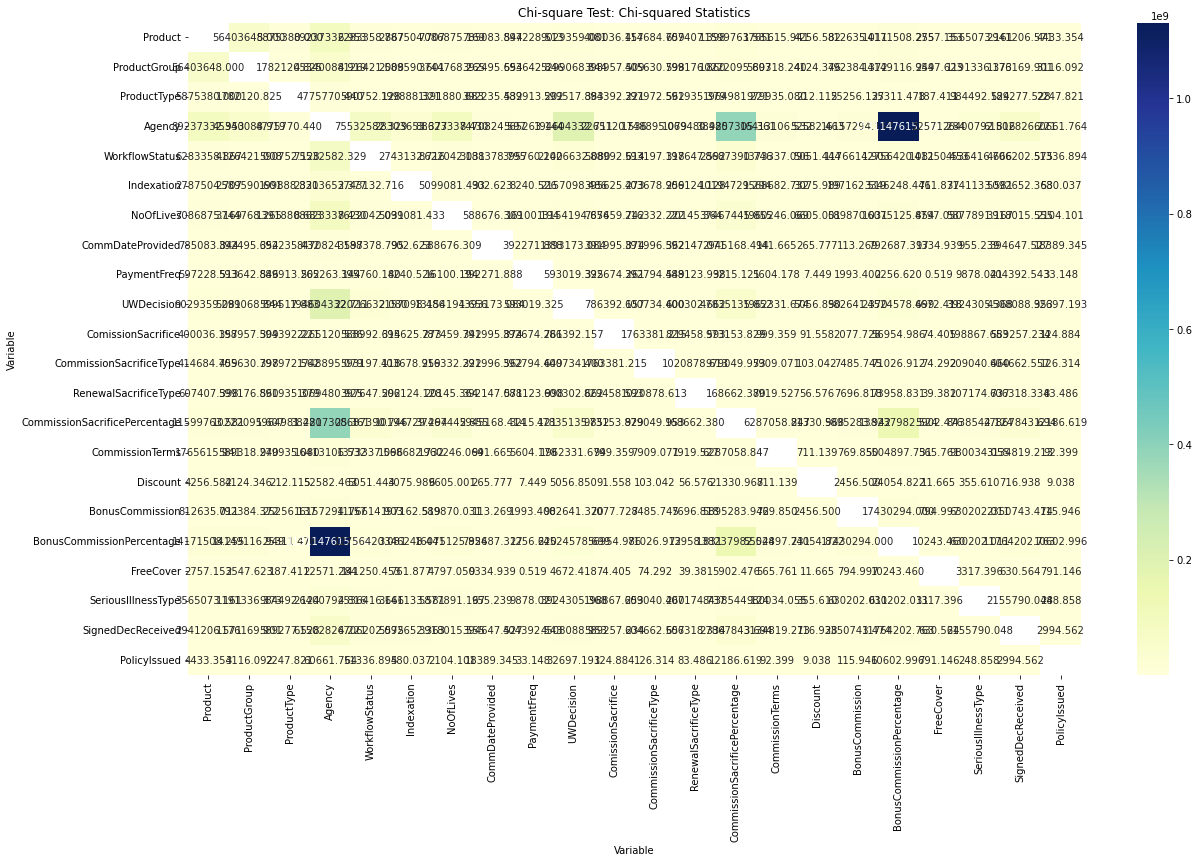

In [38]:
# Create an empty dataframe to store Chi-squared statistics
chi2_stats_df = pd.DataFrame(index=train_data.select_dtypes(include='float64').columns, columns=train_data.select_dtypes(include='float64').columns)

# Perform chi-square test for each pair of categorical variables
for column1 in train_data:
    for column2 in train_data:
        if column1 != column2:
            contingency_table = pd.crosstab(train_data[column1], train_data[column2])
            chi2_stat, _, _, _ = chi2_contingency(contingency_table)
            chi2_stats_df.loc[column1, column2] = chi2_stat

# Create a heatmap of the Chi-squared statistics
plt.figure(figsize=(20, 12))
sns.heatmap(chi2_stats_df.astype(float), annot=True, fmt=".3f", cmap='YlGnBu')
plt.xlabel('Variable')
plt.ylabel('Variable')
plt.title('Chi-square Test: Chi-squared Statistics')
plt.show()

When calculated on the balanced dataset, PolicyIssued still seems to have stronger associations with variables like WorkflowStatus, UWDecision, CommDateProvided and Agency.

### Feature Selection Conclusions

Agency and WorkflowStatus occur in the majority of the analyses, implying that they are the most essential variables for predicting the conversion of life assurance apps. UWDecision and CommDateProvided might also be considered because they occur consistently in various techniques. These features might serve as a solid starting point for developing a predictive model. 

## Undersampling

### Random Forest Feature Importance Scoring

In [4]:
# Define features and target variable
features = ['Product', 'ProductGroup', 'ProductType', 'Agency', 'WorkflowStatus', 'Indexation', 'NoOfLives',
            'CommDateProvided', 'PaymentFreq', 'UWDecision', 'ComissionSacrifice', 'CommissionSacrificeType',
            'RenewalSacrificeType', 'CommissionTerms', 'Discount', 'BonusCommission', 'FreeCover',
            'SeriousIllnessType', 'SignedDecReceived']
target = 'PolicyIssued'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Perform undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Get feature importances
feature_importances = pd.Series(rf_classifier.feature_importances_, index=features).sort_values(ascending=False)

# Print feature importances
print("Feature Importances:")
print(feature_importances)

Feature Importances:
Agency                     0.482216
WorkflowStatus             0.243637
UWDecision                 0.108249
CommDateProvided           0.052452
SignedDecReceived          0.016101
NoOfLives                  0.014341
SeriousIllnessType         0.011791
CommissionTerms            0.011233
Product                    0.010352
BonusCommission            0.009971
Indexation                 0.009450
ProductGroup               0.008593
ProductType                0.004539
CommissionSacrificeType    0.003970
RenewalSacrificeType       0.003880
ComissionSacrifice         0.003354
Discount                   0.002752
PaymentFreq                0.002105
FreeCover                  0.001014
dtype: float64


### Gradient Boosting Feature Importance Scoring

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Perform undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Train a Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_classifier.fit(X_train_resampled, y_train_resampled)

# Get feature importances
feature_importances = pd.Series(gb_classifier.feature_importances_, index=features).sort_values(ascending=False)

# Print feature importances
print("Feature Importances:")
print(feature_importances)

Feature Importances:
WorkflowStatus             0.808153
Agency                     0.085664
UWDecision                 0.037759
CommDateProvided           0.022610
ProductGroup               0.014280
SignedDecReceived          0.009315
NoOfLives                  0.006987
BonusCommission            0.005263
ProductType                0.004414
Product                    0.003271
CommissionTerms            0.000653
SeriousIllnessType         0.000438
RenewalSacrificeType       0.000387
Indexation                 0.000339
ComissionSacrifice         0.000272
CommissionSacrificeType    0.000145
Discount                   0.000049
PaymentFreq                0.000000
FreeCover                  0.000000
dtype: float64


### LightGBM Scoring

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Perform undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Train a Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_classifier.fit(X_train_resampled, y_train_resampled)

# Get feature importances
feature_importances = pd.Series(gb_classifier.feature_importances_, index=features).sort_values(ascending=False)

# Print feature importances
print("Feature Importances:")
print(feature_importances)

Feature Importances:
WorkflowStatus             0.808153
Agency                     0.085664
UWDecision                 0.037759
CommDateProvided           0.022610
ProductGroup               0.014280
SignedDecReceived          0.009315
NoOfLives                  0.006987
BonusCommission            0.005263
ProductType                0.004414
Product                    0.003271
CommissionTerms            0.000653
SeriousIllnessType         0.000438
RenewalSacrificeType       0.000387
Indexation                 0.000339
ComissionSacrifice         0.000272
CommissionSacrificeType    0.000145
Discount                   0.000049
PaymentFreq                0.000000
FreeCover                  0.000000
dtype: float64


### Cramer's V

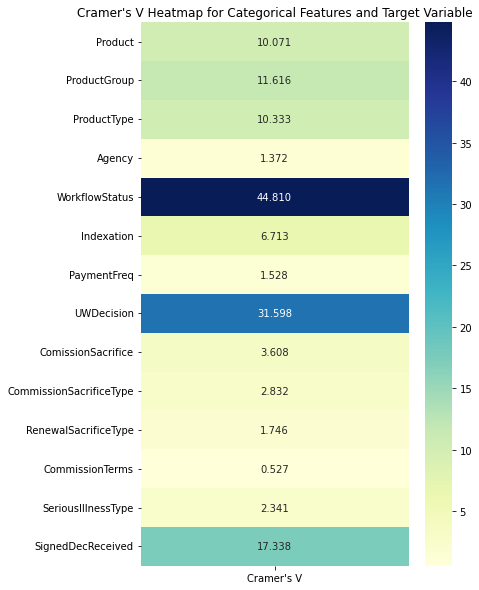

In [12]:
# Define the categorical features
categorical_features = ['Product', 'ProductGroup', 'ProductType', 'Agency', 'WorkflowStatus', 'Indexation', 'PaymentFreq',
                        'UWDecision', 'ComissionSacrifice', 'CommissionSacrificeType', 'RenewalSacrificeType',
                        'CommissionTerms', 'SeriousIllnessType', 'SignedDecReceived']
target = 'PolicyIssued'

# Perform undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(df[categorical_features + [target]], df[target])

# Create a DataFrame from the undersampled data
undersampled_df = pd.DataFrame(X_train_resampled, columns=categorical_features + [target])

# Calculate Cramer's V between each categorical feature and the target variable
cramer_v_matrix = np.zeros((len(categorical_features), 1))

for i, feature in enumerate(categorical_features):
    # Create a contingency table
    contingency_table = pd.crosstab(undersampled_df[feature], undersampled_df[target])
    
    # Calculate the chi-squared statistic and p-value
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    # Calculate Cramer's V
    num_rows = contingency_table.shape[0]
    cramer_v = np.sqrt(chi2 / (num_rows * min(contingency_table.shape) - 1))
    
    cramer_v_matrix[i, 0] = cramer_v

# Create a DataFrame with Cramer's V values
cramer_v_df = pd.DataFrame(cramer_v_matrix, columns=['Cramer\'s V'], index=categorical_features)

# Create a heatmap using Seaborn
plt.figure(figsize=(6, 10))
sns.heatmap(cramer_v_df, annot=True, fmt=".3f", cmap='YlGnBu')
plt.title("Cramer's V Heatmap for Categorical Features and Target Variable")
plt.show()

Assessing Feature Importance and correlation with target variable on undersampled dataset does not change the above conclusions on Feature Importance evaluation 